In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import torch
import cv2
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from torchvision.transforms import ToTensor
from skimage import io
from matplotlib import pyplot as plt

# 7 classes
classes = { 0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

def conv_block(in_chnl, out_chnl, pool=False, padding=1):
    layers = [
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3, padding=padding),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# Model we are using
class Model(nn.Module):
    def __init__(self, in_chnls, num_cls):
        super().__init__()

        self.conv1 = conv_block(in_chnls, 64, pool=True)
        self.conv2 = conv_block(64, 128, pool=True)             
        self.resnet1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128)) 
        
        self.conv3 = conv_block(128, 256, pool=True)     
        self.conv4 = conv_block(256, 512, pool=True)   
        self.resnet2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))  
        
        self.classifier = nn.Sequential(nn.MaxPool2d(3),
                                        nn.Flatten(),
                                        nn.Linear(512, num_cls)) 
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.resnet1(out) + out
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.resnet2(out) + out
        
        return self.classifier(out)

def device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/CV Junior TengriLab/haarcascade_frontalface_default.xml')

def img2tensor(x):
    transform = transforms.Compose(
            [transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))])
    return transform(x)

model = Model(1, 7)
softmax = torch.nn.Softmax(dim=1)
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/CV Junior TengriLab/FER2013-Resnet9.pth', 
                                 map_location=device()))

def predict(x):
    out = model(img2tensor(x)[None])
    scaled = softmax(out)
    prob = torch.max(scaled).item()
    label = classes[torch.argmax(scaled).item()]
    return {'emotion': label, 'probability': prob}

In [ ]:
# Adding url or address of pics
url = ['https://i.pinimg.com/originals/24/00/82/240082f1b539c2b3bf0ffdd8800e7cb3.jpg',
       'https://media.bizj.us/view/img/10608131/howtofear*750xx7360-4160-0-0.jpg',
       'https://image.freepik.com/free-photo/curly-man-with-broad-smile-shows-perfect-teeth-being-amused-by-interesting-talk-has-bushy-curly-dark-hair-stands-indoor-against-white-blank-wall_273609-17092.jpg']

Face id:1, Happy:0.84, bbox:[161,77,352,268]


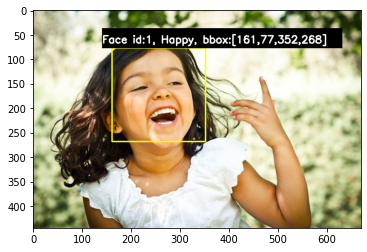

Face id:2, Fear:0.81, bbox:[303,61,507,265]


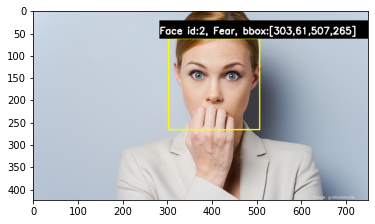

Face id:3, Happy:0.38, bbox:[220,96,407,283]


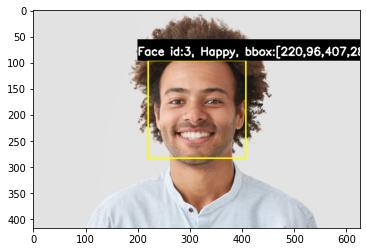

In [ ]:
faces = len(url)
count = 0
# prob = str(prediction['probability'])
for face in url:
    count = count + 1
    c = str(count)
    image = io.imread(face)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    faces = face_cascade.detectMultiScale(img). # Detect a face

    for (x,y,w,h) in faces:
        x1 = str(x)
        y1 = str(y)
        x2 = str(x + w)
        y2 = str(y + h)
        cv2.rectangle(image, (x,y), (x+w,y+h), (250,255,0), 2) ## bbox
        cv2.rectangle(image, (x-20, y), (x+470, y-40), (0,0,0), -1) ## background
        roi = img[y:y+h, x:x+h]
        pic_resize = cv2.resize(roi, (48, 48))
        frame = img2tensor(pic_resize)
        prediction = predict(frame)
        prob = str(float("{:.2f}".format(prediction['probability'])))
        bb = " bbox:[" + x1 + "," + y1 + "," + x2 + "," + y2 + "]"
        # cv2.putText(image, "Face id:" + c + f", {prediction['emotion']}:" + prob + "," + bb,
        #             (x-20, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        
        cv2.putText(image, "Face id:" + c + f", {prediction['emotion']}," + bb,
                    (x-20, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
    
    print("Face id:" + c + f", {prediction['emotion']}:" + prob + "," + bb)
    plt.imshow(image)
    plt.show()